In [38]:
import os
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image, ImageFilter, ImageEnhance, ImageDraw, ImageOps
import numpy as np
from IPython.display import display
import IPython.display
import matplotlib.pyplot as plt
import json

%run utils.ipynb

In [39]:
config = Config()

In [40]:
%%time
image_fnames = []

for (dir_path, dir_names, fnames) in os.walk(config.dataset_source):
    image_fnames.extend(map(lambda fn: os.path.join(dir_path, fn), fnames))

print(f'Found {len(image_fnames)} images under "{config.dataset_source}"')

Found 9145 images under "dataset_source/101_ObjectCategories"
CPU times: user 8.68 ms, sys: 4.05 ms, total: 12.7 ms
Wall time: 12.2 ms


In [41]:
print(f'Start making {config.dataset_sample_count} sample images from scratch under "{config.dataset_path}"')

Start making 10000 sample images from scratch under "dataset"


In [42]:
%%time
if not os.path.exists(config.dataset_path):
    print(f'Creating "{config.dataset_path}"')
    os.mkdir(config.dataset_path)
else:
    print(f'Cleaning "{config.dataset_path}"')
    removed = 0
    
    for fn in os.listdir(config.dataset_path):
        if fn.endswith(".png") or fn.endswith(".json"):
            os.remove(os.path.join(config.dataset_path, fn))
            removed += 1

    print(f'Removed {removed} samples under "{config.dataset_path}"')

Cleaning "dataset"
Removed 9146 samples under "dataset"
CPU times: user 12 ms, sys: 97.1 ms, total: 109 ms
Wall time: 115 ms


In [43]:
def preprocess_image_v1(img):
    a = img.convert('L')
    b = a.filter(ImageFilter.SMOOTH)
    c = ImageEnhance.Sharpness(b).enhance(0.5)
    d = c.filter(ImageFilter.CONTOUR)
    e = ImageOps.invert(d)
    return e

In [44]:
def preprocess_image_v2(img):
    min_size = min(img.width, img.height)
    crop_rect = (
        (img.width - min_size) // 2, 
        (img.height - min_size) // 2, 
        (img.width + min_size) // 2,
        (img.height + min_size) // 2
    )
    
    a_ = img.crop(crop_rect)
    a = a_.resize((32 + 2, 32 + 2))
    b = a.filter(ImageFilter.SMOOTH)
    c = b.filter(ImageFilter.CONTOUR)
    d = ImageOps.crop(c, 1)
    e = d.convert('L')
    f = ImageOps.invert(e)
    g = f.point(lambda p: 255 if p > 30 else 0)
    return g

In [45]:
def preprocess_image(img):
    return preprocess_image_v2(img)

In [46]:
def extract_random_square(img, square_size):
    if img.width >= square_size and img.height >= square_size:
        offsets = np.random.normal(0, 1/3, 2)
        offsets = np.clip(offsets, -1, 1)
    else:
        offsets = (0, 0)
        
    half_img_width = img.width // 2
    half_img_height = img.height // 2
    half_square_size = square_size // 2
    offset_space_x = half_img_width - half_square_size
    offset_space_y = half_img_height - half_square_size
    square_center = (
        half_img_width + int(offset_space_x * offsets[0]),
        half_img_height + int(offset_space_y * offsets[0])
    )
    square_coords = (
        square_center[0] - half_square_size,
        square_center[1] - half_square_size,
        square_center[0] + half_square_size,
        square_center[1] + half_square_size
    )
    return img.crop(square_coords), square_center

In [47]:
original_fnames = {}

for i in tqdm(range(config.dataset_sample_count)):
    fname_i = i % len(image_fnames)
    fname = image_fnames[fname_i]

    if False:
        with Image.open(fname) as source_img:
            source_img1 = preprocess_image(source_img)
            sample_img, center_coords = extract_random_square(source_img1, config.kernel_size)
            fname_stem = Path(fname).stem
            fname_prefix = os.path.dirname(fname).replace(os.path.sep, '_')
            sample_img_fname = f'{fname_prefix}_{fname_stem}@{center_coords[0]},{center_coords[1]}.png'
            sample_img.save(os.path.join(config.dataset_path, sample_img_fname), format='png')
    else:
        with Image.open(fname) as source_img:
            source_img1 = preprocess_image(source_img)
            fname_stem = Path(fname).stem
            fname_prefix = os.path.dirname(fname).replace(os.path.sep, '_')
            sample_img_fname = f'{fname_prefix}_{fname_stem}.png'
            source_img1.save(os.path.join(config.dataset_path, sample_img_fname), format='png')
        
        original_fnames[sample_img_fname] = fname

with open(os.path.join(config.dataset_path, '_original_fnames.json'), 'w') as f:
    json.dump(original_fnames, f, indent=0)

  0%|          | 0/10000 [00:00<?, ?it/s]

Image index 8848 dataset_source/101_ObjectCategories/crayfish/image_0016.jpg



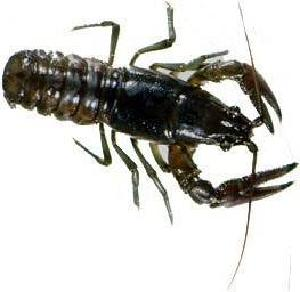
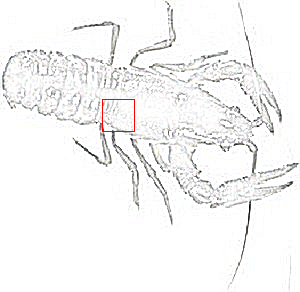
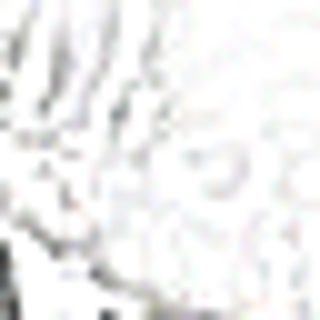

In [30]:
assert len(image_fnames) > 0
i = np.random.randint(len(image_fnames))

print(f'Image index {i} {image_fnames[i]}')
img = Image.open(image_fnames[i])
#display(img)
#display(img.filter(ImageFilter.CONTOUR))

img1 = ImageEnhance.Sharpness(img.filter(ImageFilter.SMOOTH)).enhance(0.5).filter(ImageFilter.CONTOUR)
#display(img1)


# display(img.filter(ImageFilter.SMOOTH).filter(ImageFilter.CONTOUR))
#display(img.filter(ImageFilter.SMOOTH).filter(ImageFilter.FIND_EDGES))
img2 = None

if img1.width >= config.kernel_size and img1.height >= config.kernel_size:
    offsets = np.random.normal(0, 1/3, 2)
    offsets = np.clip(offsets, -1, 1)
    half_img_width = img1.width // 2
    half_img_height = img1.height // 2
    half_kernel_size = config.kernel_size // 2
    offset_space_x = half_img_width - half_kernel_size
    offset_space_y = half_img_height - half_kernel_size
    patch_center = (
        half_img_width + offset_space_x * offsets[0],
        half_img_height + offset_space_y * offsets[0]
    )
    
    patch_coords = (
        patch_center[0] - half_kernel_size,
        patch_center[1] - half_kernel_size,
        patch_center[0] + half_kernel_size,
        patch_center[1] + half_kernel_size
    )
    img2 = img1.crop(patch_coords).resize((320, 320))
    ImageDraw.Draw(img1).rectangle(patch_coords, outline='red')

display_images([img, img1, img2])

In [53]:
def erode(cycles, image):
    for _ in range(cycles):
        image = image.filter(ImageFilter.MinFilter(3))
    return image

def dilate(cycles, image):
    for _ in range(cycles):
        image = image.filter(ImageFilter.MaxFilter(3))
    return image

Image index 5772 dataset_source/101_ObjectCategories/sunflower/image_0008.jpg entropy 8.93



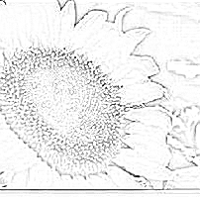
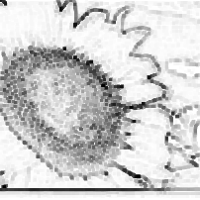
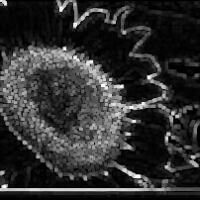
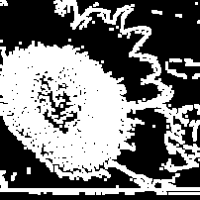
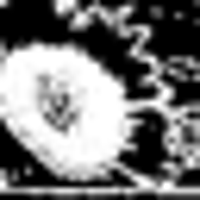
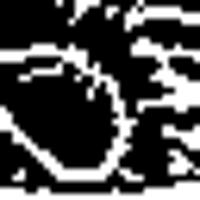

In [602]:
assert len(image_fnames) > 0
i = np.random.randint(len(image_fnames))
#i = 3343
img = Image.open(image_fnames[i])
print(f'Image index {i} {image_fnames[i]} entropy {img.entropy():.2f}')
#img1 = ImageEnhance.Sharpness(img.filter(ImageFilter.SMOOTH)).enhance(0.5).filter(ImageFilter.CONTOUR)
min_size = min(img.width, img.height)
crop_rect = (
    (img.width - min_size) // 2, 
    (img.height - min_size) // 2, 
    (img.width + min_size) // 2,
    (img.height + min_size) // 2
)
img1 = img.crop(crop_rect)

img2 = ImageOps.crop(img1.filter(ImageFilter.SMOOTH).filter(ImageFilter.CONTOUR).convert('L'), 1)
img3 = erode(1, img2)
img4 = ImageOps.invert(img3)
point_thres = 30
img5 = img4.point(lambda p: 255 if p > point_thres else 0)
#img6 = erode(1, img5.resize((32, 32)))
img6 = img5.resize((32, 32))
img7 = ImageOps.invert(ImageOps.crop(img1.resize((32 + 2, 32 + 2)).filter(ImageFilter.SMOOTH).filter(ImageFilter.CONTOUR), 1).convert('L')).point(lambda p: 255 if p > point_thres else 0)

display_images([i.resize((200, 200)) for i in [img2, img3, img4, img5, img6, img7]])


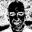
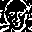

In [592]:
display_images([img6, img7])
#ImageOps.invert(img1.resize((32, 32)).convert('L')).resize((200, 200))
#display_images([img1, img1.convert('L'), ImageOps.crop(img1.filter(ImageFilter.SMOOTH).filter(ImageFilter.CONTOUR).convert('L'), 1)])

In [173]:
histogram = [(i,h) for i, h in enumerate(img2.histogram())]
histogram.sort(key=lambda h: h[1], reverse=True)
#np.array(histogram) * 100 / np.sum(histogram)

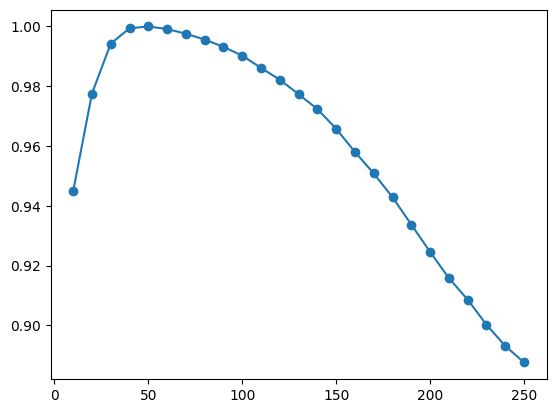

In [225]:
points = []

for thr in range(10, 255, 10):
    #print(f'thr {thr} {img2.point(lambda p: 255 if p > thr else 0).entropy()}')
    points.append(img2.point(lambda p: 255 if p > thr else 0).entropy())
    pass

plt.plot(range(10, 255, 10), points, marker='o')
plt.show()